<a href="https://colab.research.google.com/github/amoyag/Biofisica/blob/main/S1_introduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

#@title Setup mínimo para Colab (NumPy, SciPy, Matplotlib, Pandas)
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8')


## Ecuaciones diferenciales para la simulación de circuitos biológicos.
En biología de sistemas, las concentraciones de mRNA/proteína cambian en el tiempo según producción y degradación/dilución. Un gen regulado simple se modela como:

$$\frac{dY}{dt} = P(t) - \alpha Y$$


donde $P(t)$ es la tasa efectiva de producción (que puede depender de entradas/reguladores) y $\alpha$ es la tasa de pérdida. Esta formulación permite estudiar tiempos de respuesta, estados estacionarios y robustez de los circuitos$^1$.

En el taller 3, discutimos que proteínas y enzimas pueden comportarse como elementos de computación; las ODEs capturan esa computación distribuida sin “cables”, mediada por difusiones y acoplamientos alostéricos.


[1. Ver capítulos 1 y 2 de Alon U. Introduction to systems Biology]

En estas prácticas vamos a usar una API mínima que puedas “montar” como LEGO:

```python
def model(t, y, params): — modelo ODE del circuito (devuelve la derivada de y respecto al tiempo).
```
```python
simulate(model, y0, t_span, t_eval, params) — integrador común (SciPy).
plot_timeseries(sol, labels) — gráfica unificada.
```
```python
Bloques de entrada (step_input, pulse_input) y funciones reguladoras (hill_activation, hill_repression)
```

Así podrás usar el código para realizar simulaciones de circuitos biológicos y entender sus propiedades con una compresión mínima de Python.

In [3]:

#@title Bloques reutilizables: simulación y visualización

def simulate(model, y0, t_span, t_eval, params):
    """Integra un sistema ODE con solve_ivp."""
    sol = solve_ivp(lambda t, y: model(t, y, params),
                    t_span=t_span, y0=y0, t_eval=t_eval,
                    method='RK45', rtol=1e-6, atol=1e-9)
    return sol

def plot_timeseries(sol, labels=None, title="Dinámica temporal"):
    plt.figure(figsize=(7,4))
    for i in range(sol.y.shape[0]):
        lab = labels[i] if labels and i < len(labels) else f"var{i}"
        plt.plot(sol.t, sol.y[i], label=lab)
    plt.xlabel("Tiempo")
    plt.ylabel("Concentración (a.u.)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Regulación tipo Hill (activación y represión)
def hill_activation(x, K, n):
    """f(x) = x^n / (K^n + x^n)"""
    return (x**n) / (K**n + x**n)

def hill_repression(x, K, n):
    """f_rep(x) = 1 / (1 + (x/K)^n)"""
    return 1.0 / (1.0 + (x / K)**n)

# Entradas (estímulos)
def step_input(t, t_on=10.0, val_before=0.0, val_after=1.0):
    return val_before if t < t_on else val_after

def pulse_input(t, t_on=10.0, t_off=20.0, val=1.0):
    return val if t_on <= t < t_off else 0.0


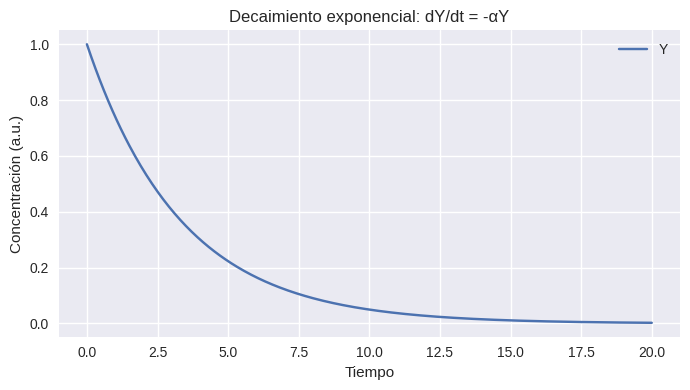

In [4]:

#@title Ejemplo 1: decaimiento exponencial (ODE 1 variable)

def linear_decay_model(t, y, params):
    alpha = params.get("alpha", 0.5)
    dy = -alpha*y[0]
    return [dy]

y0 = [1.0]
t_eval = np.linspace(0, 20, 400)
sol = simulate(linear_decay_model, y0, (0, 20), t_eval, {"alpha":0.3})
plot_timeseries(sol, labels=["Y"], title="Decaimiento exponencial: dY/dt = -αY")


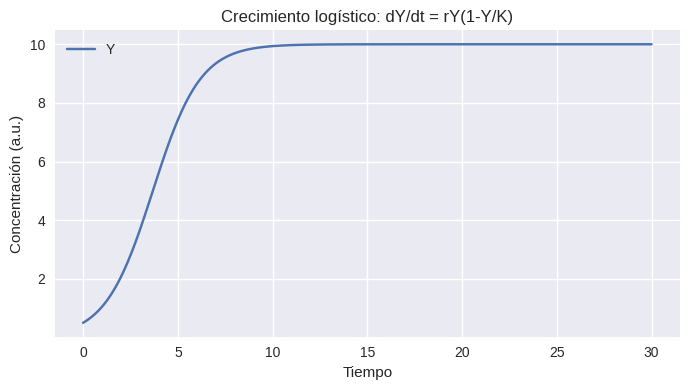

In [5]:

#@title Ejemplo 2: crecimiento logístico (competencia/recursos)

def logistic_model(t, y, params):
    r = params.get("r", 1.0)
    K = params.get("K", 10.0)
    dy = r*y[0]*(1 - y[0]/K)
    return [dy]

y0 = [0.5]
t_eval = np.linspace(0, 30, 600)
sol = simulate(logistic_model, y0, (0, 30), t_eval, {"r":0.8, "K":10})
plot_timeseries(sol, labels=["Y"], title="Crecimiento logístico: dY/dt = rY(1-Y/K)")


## Lógica Booleana vs lógica difusa
La actividad de una proteína con dos entradas puede aproximarse por AND/OR (Boole) o por una respuesta gradual tipo Hill (difusa). Los sistemas vivos suelen operar “entre” ambos extremos, beneficiándose de respuestas continuas y robustas. Recuerda el [paper de Dennis Bray.](https://www.nature.com/articles/376307a0)

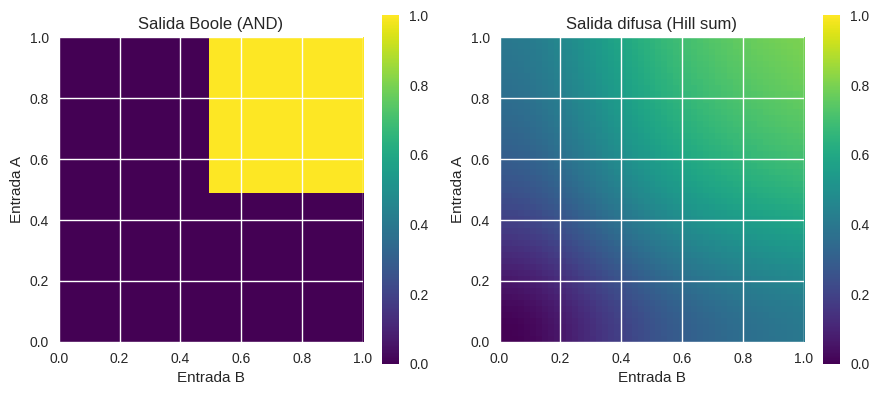

In [16]:

#@title Comparación Boole vs. difusa

def boolean_output(a, b, mode="AND", thr=0.5):
  #thr es el umbral de valores A y B que dan respuesta
    A = 1.0 if a >= thr else 0.0
    B = 1.0 if b >= thr else 0.0
    if mode == "AND":
        return 1.0 if (A==1.0 and B==1.0) else 0.0
    elif mode == "OR":
        return 1.0 if (A==1.0 or B==1.0) else 0.0
    elif mode == "NAND":
        return 0.0 if (A==1.0 and B==1.0) else 1.0
    else:
        raise ValueError("mode desconocido")

def fuzzy_output(a, b, K=0.5, n=2):
    # salida proporcional a suma de activaciones tipo Hill
    return 0.5*(hill_activation(a, K, n) + hill_activation(b, K, n))

# Barrido de entradas y visualización
A_vals = np.linspace(0, 1, 51)
B_vals = np.linspace(0, 1, 51)

Z_bool = np.zeros((len(A_vals), len(B_vals)))
Z_fuzzy = np.zeros_like(Z_bool)

for i, A in enumerate(A_vals):
    for j, B in enumerate(B_vals):
        Z_bool[i,j] = boolean_output(A, B, mode="AND", thr=0.5)
        Z_fuzzy[i,j] = fuzzy_output(A, B, K=0.5, n=2)

fig, axs = plt.subplots(1,2, figsize=(9,4))
im0 = axs[0].imshow(Z_bool, origin='lower', extent=[0,1,0,1], vmin=0, vmax=1, cmap='viridis')
axs[0].set_title("Salida Boole (AND)")
axs[0].set_xlabel("Entrada B"); axs[0].set_ylabel("Entrada A")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(Z_fuzzy, origin='lower', extent=[0,1,0,1], vmin=0, vmax=1, cmap='viridis')
axs[1].set_title("Salida difusa (Hill sum)")
axs[1].set_xlabel("Entrada B"); axs[1].set_ylabel("Entrada A")
plt.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()


### Ejercicio
Juega con $n$ (coeficiente de Hill) y $K$ (umbral). ¿Cuándo la respuesta difusa se acerca a un interruptor digital? Relaciona esto con la idea de “proteína interruptor” vs. “regulación gradual” que [describe Bray.]((https://www.nature.com/articles/376307a0))

## Un circuito mínimo: gen activado por una entrada (ODE modular)
Este bloque introduce el patrón clave que reutilizaremos en sesiones posteriores.

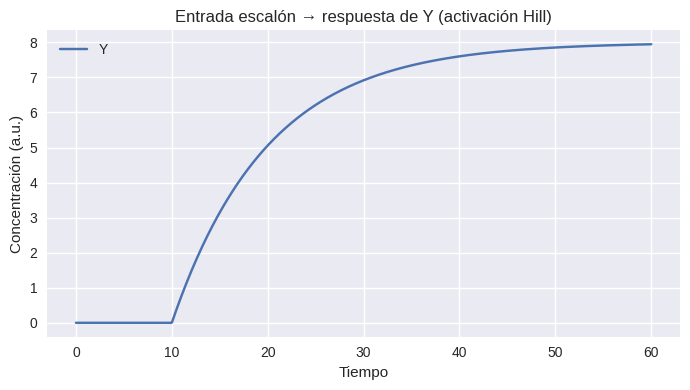

In [23]:
#@title Circuito 0: gen Y activado por una entrada S(t) con degradación

def gene_simple_model(t, y, params):
    # y[0] := Y (proteína)
    S_func = params["S_func"]                 # entrada tiempo-dependiente (es una función)
    S_value = S_func(t)                       # Evaluar la función S_func en el tiempo t
    Pmax = params.get("Pmax", 1.0)          # producción máxima
    K = params.get("K", 0.5)
    n = params.get("n", 2)
    alpha = params.get("alpha", 0.2)
    prod = Pmax * hill_activation(S_value, K, n)  # producción regulada, ahora con el valor numérico de S
    dy = prod - alpha*y[0]                  # balance producción/decadencia
    return [dy]

y0 = [0.0]
t_eval = np.linspace(0, 60, 900)
params = {"S_func": lambda t: step_input(t, t_on=10, val_before=0.0, val_after=1.0),
          "Pmax": 1.0, "K":0.5, "n":2, "alpha":0.1}
sol = simulate(gene_simple_model, y0, (0, 60), t_eval, params)
plot_timeseries(sol, labels=["Y"], title="Entrada escalón → respuesta de Y (activación Hill)")